In [1]:
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import spectral as spy
from skimage.segmentation import mark_boundaries
from sklearn import manifold

sys.path.append('../../../../hsi/src/python')
from hsi.datafiles.hyperspectral_image_datafile import HyperspectralImageDataFile
from hsi.datafiles.envicontainer import ENVIContainer
from hsi.modules.clustering.hslic import HSLIC
sys.path.append('../aster-loader/')
from plots import plot_embedding
from segmentation  import watershed_segmentation, spectral_segmentation

# Hyperspectral Image Analysis
This notebook explains how to do the three following evaluations:
- Image low dimensional embedding
- Image segmentation
- Spectra clustering

These experiments should provide alternatives for knowledge discovery in hyperspectral images

In [2]:
h = HyperspectralImageDataFile()
h.load_data('../../data/hiperespectral/2002527916_Subset_Envi.hdr', 
            container=ENVIContainer())

78 x 87 x 9 hyperspectralimagedatafile

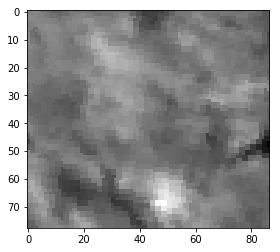

In [3]:
plt.imshow(h.get_visible())

In [4]:
cube = h.get_cube()
pc   = h.get_point_cloud()
seg  = h.get_segments()
segv = h.get_segments_visible()

print(cube.shape)
print(pc.shape)
print(seg.shape)
print(segv.shape)

(78, 87, 9)
(6786, 11)
(6786,)
(78, 87)


In [5]:
flattened_cube = np.reshape(cube, (cube.shape[0]*cube.shape[1], cube.shape[2]))
print(flattened_cube.shape)

(6786, 9)


# Manifold Learning

## Multi-Dimensional Scaling (MDS)

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.
In general, is a technique used for analyzing similarity or dissimilarity data. MDS attempts to model similarity or dissimilarity data as distances in a geometric spaces. The data can be ratings of similarity between objects, interaction frequencies of molecules, or trade indices between countries.

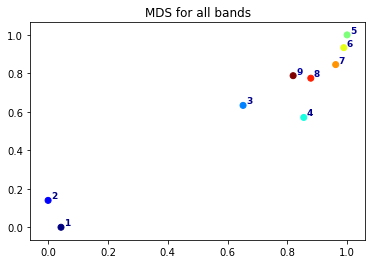

In [6]:
target = list(range(cube.shape[-1]))
n_components = 2

mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y_mds = mds.fit_transform(flattened_cube.T)

plot_embedding(Y_mds, flattened_cube.T, target, 'MDS for all bands')

##  t-distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE (TSNE) converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. This allows t-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:
- Revealing the structure at many scales on a single map
- Revealing data that lie in multiple, different, manifolds or clusters
- Reducing the tendency to crowd points together at the center

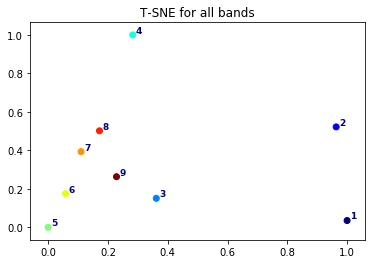

In [7]:
target = list(range(cube.shape[-1]))
n_components = 2

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y_tsne = tsne.fit_transform(flattened_cube.T)

plot_embedding(Y_tsne, flattened_cube.T, target, 'T-SNE for all bands')

# Segmentation
# Spectral Clustering Segmentation

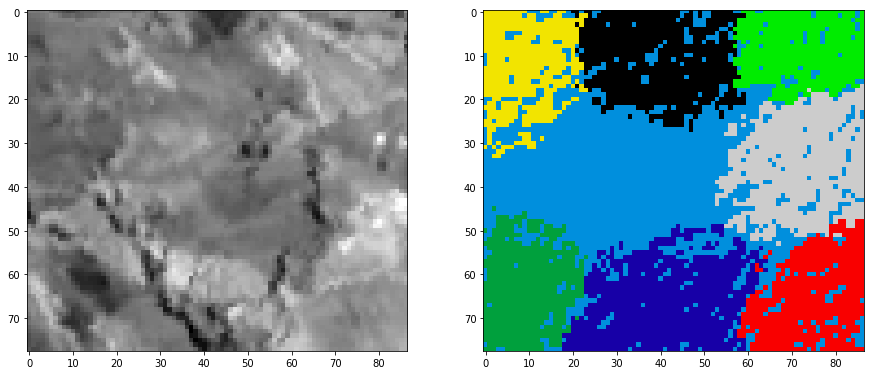

In [8]:
img = cube[:, :, 1]
label_img = spectral_segmentation(img, n_clusters=8)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(label_img, cmap=plt.cm.spectral)

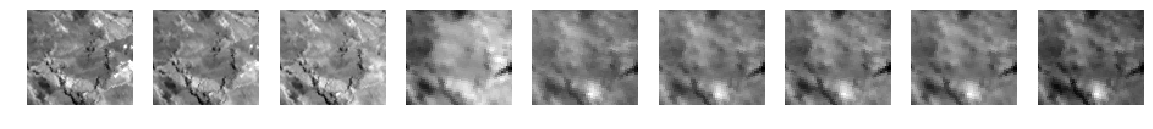

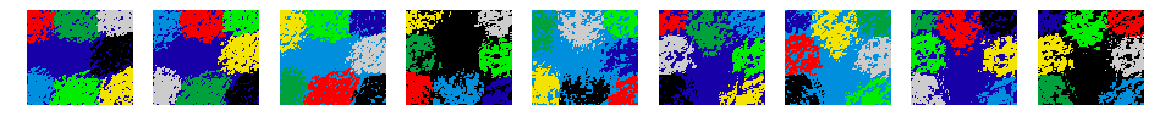

In [9]:
n = cube.shape[-1]

fig= plt.figure(figsize=(20, 5))
for i in range(n):
    plt.subplot(1, 9, i + 1)
    plt.cm.spectral
    plt.imshow(cube[:, :, i], cmap=plt.cm.gray)
    plt.axis('off')

fig = plt.figure(figsize=(20, 5))
for i in range(n):
    img  = cube[:, :, i]
    label_img = spectral_segmentation(img, n_clusters=8)
    
    plt.subplot(1, 9, i + 1)
    plt.imshow(label_img, cmap=plt.cm.spectral)
    plt.axis('off')

# Watershed Segmentation
(1979) Beucher et. al., *Use of Watersheds in Contour Detection* - [Paper](http://cmm.ensmp.fr/~beucher/publi/watershed.pdf)

Basic idea follows the image
![Watershed Example](http://cmm.ensmp.fr/~beucher/lpe1.gif 'Watershed Example')

References
1. [http://cmm.ensmp.fr/~beucher/wtshed.html](http://cmm.ensmp.fr/~beucher/wtshed.html) (image)
2. [http://docs.opencv.org/3.2.0/d3/db4/tutorial_py_watershed.html](http://docs.opencv.org/3.2.0/d3/db4/tutorial_py_watershed.html) (implementation)

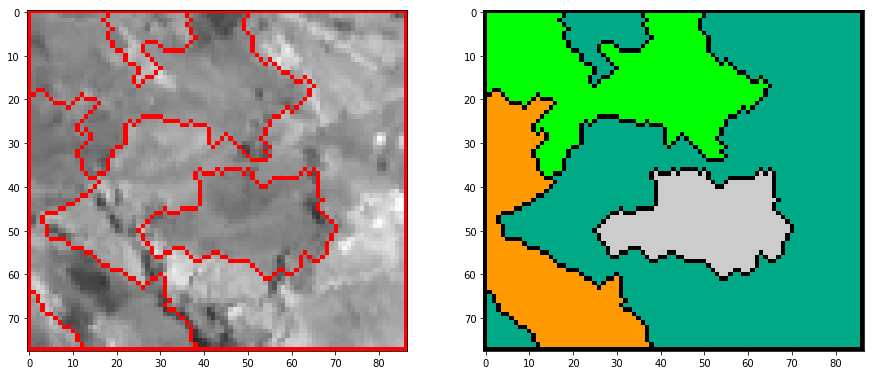

In [10]:
img = cube[:, :, 1]
kwargs = {
    'kernel': np.ones((3, 3), np.uint8),
    'opening_iters': 2,
    'dilation_iters': 3
}
marked_img, label_img = watershed_segmentation(img, **kwargs)


plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(marked_img, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(label_img, cmap=plt.cm.spectral)

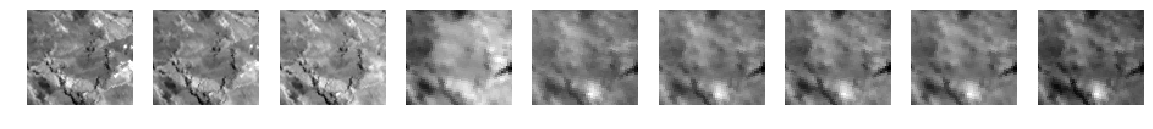

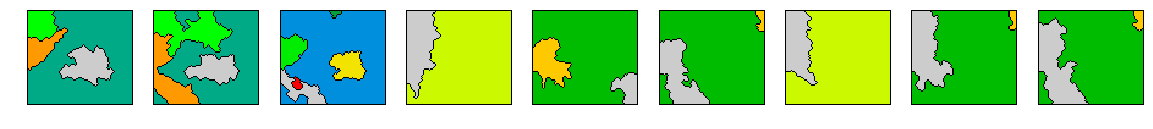

In [11]:
n = cube.shape[-1]

fig= plt.figure(figsize=(20, 5))
for i in range(n):
    plt.subplot(1, 9, i + 1)
    plt.imshow(cube[:, :, i], cmap=plt.cm.gray)
    plt.axis('off')

fig = plt.figure(figsize=(20, 5))
for i in range(n):
    img = cube[:, :, i]
    marked_img, label_img = watershed_segmentation(img, **kwargs)
    
    plt.subplot(2, 9, i + 1)
    plt.imshow(label_img, cmap=plt.cm.spectral)
    plt.axis('off')

# SEED Superpixels
(2013) Van den Bergh et. al., *SEEDS: Superpixels Extracted via Energy-Driven Sampling* - [Paper](https://arxiv.org/pdf/1309.3848.pdf)

Basic idea is to continously refine superpixels by modifying the boundaries. This is done via a energy function that enforces color similarity between boundaries and the superpixel color histogram.

In [12]:
from cv2.ximgproc import createSuperpixelSEEDS

img = cube

num_superpixels = 20
num_channels = 9
num_levels = 2

sp = createSuperpixelSEEDS(img.shape[1], img.shape[0], num_channels, num_superpixels, num_levels)

In [13]:
sp.iterate(img, 10)
sp.getNumberOfSuperpixels()

9

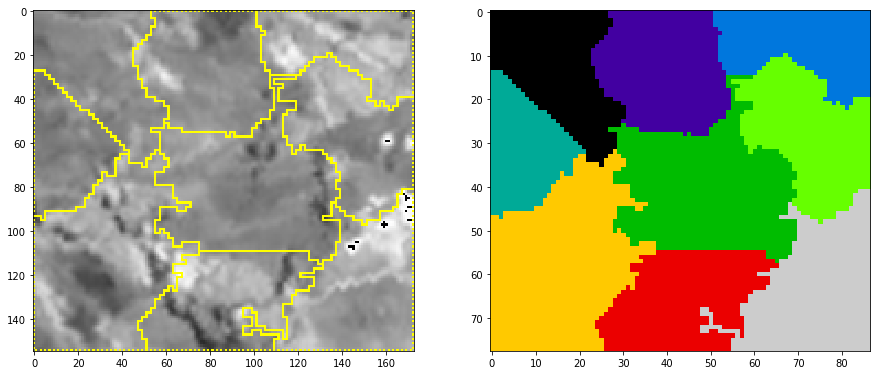

In [14]:
label_img  = sp.getLabels()
marked_img = mark_boundaries(img[:,:,0], label_img, mode='subpixel')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(marked_img, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(label_img, cmap=plt.cm.spectral)

# SLIC Superpixels
(2010) Achanta et. al., *SLIC Superpixels* - [Paper](https://infoscience.epfl.ch/record/149300/files/SLIC_Superpixels_TR_2.pdf)

In [15]:
import cv2
from cv2.ximgproc import createSuperpixelSLIC

img = cube[:,:,0]

region_size = 15
float_ruler = 10.0

sp = createSuperpixelSLIC(img, cv2.ximgproc.SLICO, region_size, float_ruler)

In [16]:
sp.iterate(100)
sp.getNumberOfSuperpixels()

28

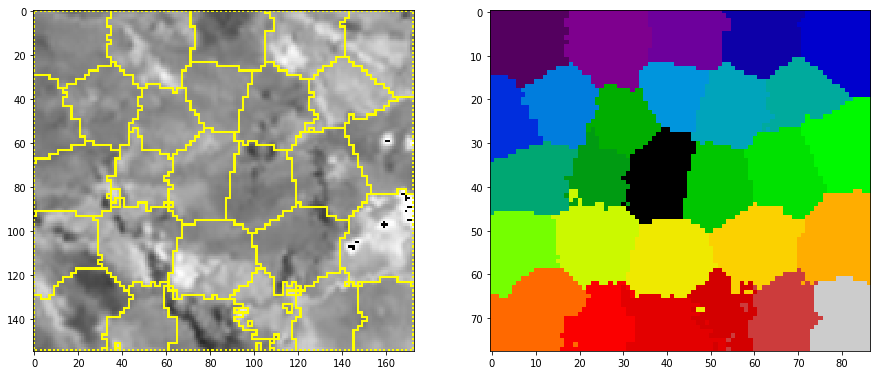

In [17]:
from skimage.segmentation import mark_boundaries

label_img = sp.getLabels()
marked_img = mark_boundaries(img, label_img, mode='subpixel')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(marked_img, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(label_img, cmap=plt.cm.spectral)

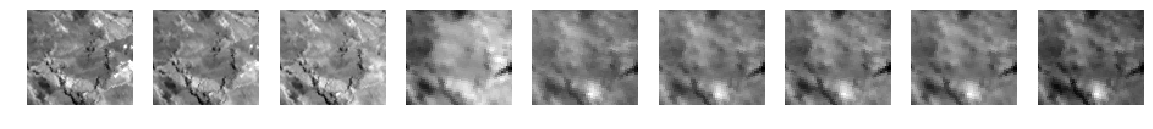

In [18]:
n = cube.shape[-1]

fig= plt.figure(figsize=(20, 5))
for i in range(n):
    plt.subplot(1, 9, i + 1)
    plt.imshow(cube[:, :, i], cmap=plt.cm.gray)
    plt.axis('off')

fig = plt.figure(figsize=(20, 5))
for i in range(n):
    img = cube[:, :, i]
    sp = createSuperpixelSLIC(img, cv2.ximgproc.SLICO, region_size, float_ruler)
    sp.iterate(100)
    
    label_img = sp.getLabels()
    marked_img = mark_boundaries(img, label_img, mode='outer')
    
    plt.subplot(2, 9, i + 1)
    plt.imshow(marked_img, cmap=plt.cm.spectral)
    plt.axis('off')

# Clustering spectra

We treat the hyperspectral image as a sequences of B-dimensional vectors instead of an image

In [19]:
spectra = flattened_cube
plt.figure(figsize=(18, 6))

pix = 0
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(spectra[pix, :])
    plt.title(f"Pixel {pix}")
    pix = pix + 1000

## DBScan

In [20]:
from sklearn.cluster import DBSCAN

dbscan_params = {
    'eps': 5.,
    'min_samples': 10,
    'metric': 'euclidean',
    'algorithm': 'auto',
    'leaf_size': 30,
    'n_jobs': 2
}

db = DBSCAN(**dbscan_params).fit(flattened_cube)

In [21]:
print(db.labels_.shape)
print(len(np.unique(db.labels_)))

(6786,)
26


In [22]:
img_shape = cube[:,:,0].shape
label_img = np.zeros(img_shape)

for i in range(len(db.labels_)):
    x, y = np.unravel_index(i, img_shape)
    label_img[x, y] = db.labels_[i]

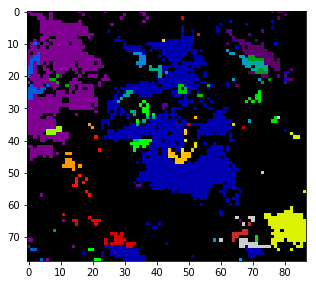

In [23]:
plt.figure(figsize=(5, 5))
plt.imshow(label_img, cmap=plt.cm.spectral)

## K-Means

In [24]:
from sklearn.cluster import KMeans

kmeans_params = {
    'n_clusters': 6,
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300,
    'tol': 0.0001,
    'precompute_distances': 'auto',
    'verbose': 0,
    'random_state': None,
    'n_jobs': 2,
    'algorithm': 'auto'
}

km = KMeans(**kmeans_params).fit(flattened_cube)

In [25]:
print(km.labels_.shape)
print(len(np.unique(km.labels_)))

(6786,)
6


In [26]:
img_shape = cube[:,:,0].shape
label_img = np.zeros(img_shape)

for i in range(len(km.labels_)):
    x, y = np.unravel_index(i, img_shape)
    label_img[x, y] = km.labels_[i]

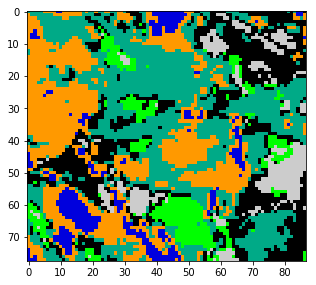

In [27]:
plt.figure(figsize=(5, 5))
plt.imshow(label_img, cmap=plt.cm.spectral)